# Analysis of unemployed Saudis
- K-means model to cluster unemployed
- Random forest regression for determinants of long term unemployment

In [1]:
# Import packages
import glob
import pandas as pd
import numpy as np
import time 
from datetime import datetime
from datetime import date
from convertdate import gregorian
from convertdate import islamic
from hijri_converter import convert
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

In [2]:
#load 3LMS dataset for nationals
df = pd.read_csv('3lms_saudi_nationals.csv')

In [3]:
df.shape

(4941, 23)

In [4]:
# create subset df of only unemployed
unemployed = df[(df['q62_paidwk7dys']=="No") 
                & 
            (df['q74b_lkfpaidjb']=='Yes, looking for paid work')
                & 
            (df['q474c_currentsit']=='Not working but looking for work')]

In [5]:
unemployed.shape

(653, 23)

In [6]:
# drop employment related variables that do not apply to the unemployed
unemployed = unemployed.drop(columns=[
                      'q83_past7daystatus',
                      'q203c_totsalmnoall',
                      'q203b_totsalm',
                      'q226_fullskilljb',
                      'q227_training',
                      'q232_jbsat',
                      'q227_training',
                      'q34_studyfield',
                      'q24_enreadwrite',
                     ])

In [7]:
# we can also drop the variables used to identify unemployment status
unemployed = unemployed.drop(columns=[
                      'q62_paidwk7dys',
                      'q1_ksacitizenship',
                      'q74b_lkfpaidjb',
                      'q474c_currentsit',
                     ])

In [8]:
unemployed.shape

(653, 11)

In [9]:
unemployed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 653 entries, 2 to 4940
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   responseid           653 non-null    int64 
 1   q2_gender            653 non-null    object
 2   URBAN_RURAL          653 non-null    object
 3   q3_province          653 non-null    object
 4   q4_area              653 non-null    object
 5   q5_age               653 non-null    int64 
 6   q15_maritalstatus    653 non-null    object
 7   q23_enprofc          653 non-null    object
 8   q32_edulevcompleted  653 non-null    object
 9   q75_seriouslylkfjb   653 non-null    object
 10  q76_hwlnglkfjb       653 non-null    object
dtypes: int64(2), object(9)
memory usage: 61.2+ KB


#### Data pre-processing requirements for machine learning model
- Convert data to numeric for ML model
- drop nulls
- scale data

In [10]:
unemployed.shape

(653, 11)

In [11]:
print(unemployed['q2_gender'].value_counts())

Female    345
Male      308
Name: q2_gender, dtype: int64


In [12]:
# Drop non-responses that can't be placed in ordinal values - (Don't know) = 5
unemployed.drop(unemployed.index[unemployed['q23_enprofc'] == "(Don't know)"], inplace = True)

In [13]:
unemployed.shape

(648, 11)

In [14]:
unemployed.drop(unemployed.index[unemployed['q32_edulevcompleted'] == '999'], inplace = True)

In [15]:
unemployed.shape

(606, 11)

In [16]:
unemployed.drop(unemployed.index[unemployed['q76_hwlnglkfjb'] == "(Don't know)"], inplace = True)

In [17]:
unemployed.drop(unemployed.index[unemployed['q76_hwlnglkfjb'] == "(Refused)"], inplace = True)

In [18]:
unemployed.shape

(600, 11)

# Ordinal variables

In [19]:
# convert english proficiency to new numeric variable
def skills(q23_enprofc):
    if q23_enprofc in ('Or not at all?'):
        return 1
    elif q23_enprofc in ('Not very well'):
        return 2
    elif q23_enprofc in ('Well'):
        return 3
    elif q23_enprofc in ('Very well'):
        return 4
    else:
        return 0
    
unemployed['skills'] = unemployed['q23_enprofc'].apply(lambda x: skills(x))

In [20]:
# convert education level to new numeric variable
# below high school, high school/diploma, college and above
def education(q32_edulevcompleted):
    if q32_edulevcompleted in ('999'):
        return 0
    elif q32_edulevcompleted in ('Primary education', 'Middle/Intermediate education'):
        return 1
    elif q32_edulevcompleted in ('Regular Secondary education', 'Vocational or Technical Secondary education', 'Diploma'):
        return 2
    else:
        return 3
    
unemployed['education'] = unemployed['q32_edulevcompleted'].apply(lambda x: education(x))

In [21]:
# convert english proficiency to new numeric variable
def job_search_duration(q76_hwlnglkfjb):
    if q76_hwlnglkfjb in ('One month or less'):
        return 1
    elif q76_hwlnglkfjb in ('More than one month, up to six months'):
        return 2
    elif q76_hwlnglkfjb in ('More than six months, less than one year'):
        return 3
    elif q76_hwlnglkfjb in ('One year or longer'):
        return 4
    
unemployed['job_search_duration'] = unemployed['q76_hwlnglkfjb'].apply(lambda x: job_search_duration(x))

In [22]:
print(df['q3_province'].value_counts())

Makkah/Jeddah        820
Riyadh               748
Eastern Province     534
Asir                 368
Madinah              348
Hail                 338
AlBaha               302
Tabuk                299
Northern Province    274
Qasim                273
Jazan                263
AlJouf               228
Najran               146
Name: q3_province, dtype: int64


In [23]:
# create unemployment rate region numeric variable
# using 2018 LFS data since it's the earliest available... 
# regional unemployment shouldnt vary much in two years, but need to find earlier data


def regional_lm_conditions(q3_province):
    if q3_province in ('Makkah/Jeddah'):
        return 11.2
    elif q3_province in ('Riyadh'):
        return 11.1
    elif q3_province in ('Eastern Province'):
        return 7.1
    elif q3_province in ('Asir'):
        return 12.9
    elif q3_province in ('Madinah'):
        return 22.4
    elif q3_province in ('Hail'):
        return 16.2
    elif q3_province in ('AlBaha'):
        return 13.7
    elif q3_province in ('Tabuk'):
        return 16.5
    elif q3_province in ('Northern Province'):
        return 15.4
    elif q3_province in ('Qasim'):
        return 14.6
    elif q3_province in ('Jazan'):
        return 19.8
    elif q3_province in ('AlJouf'):
        return 27.7
    elif q3_province in ('Najran'):
        return 12.1
    
unemployed['regional_lm_conditions'] = unemployed['q3_province'].apply(lambda x: regional_lm_conditions(x))

In [24]:
unemployed = pd.get_dummies(unemployed, columns=['URBAN_RURAL'])

In [25]:
unemployed = pd.get_dummies(unemployed, columns=['q2_gender'])

In [26]:
unemployed = pd.get_dummies(unemployed, columns=['q15_maritalstatus'])

In [27]:
unemployed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 2 to 4940
Data columns (total 21 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   responseid                               600 non-null    int64  
 1   q3_province                              600 non-null    object 
 2   q4_area                                  600 non-null    object 
 3   q5_age                                   600 non-null    int64  
 4   q23_enprofc                              600 non-null    object 
 5   q32_edulevcompleted                      600 non-null    object 
 6   q75_seriouslylkfjb                       600 non-null    object 
 7   q76_hwlnglkfjb                           600 non-null    object 
 8   skills                                   600 non-null    int64  
 9   education                                600 non-null    int64  
 10  job_search_duration                      600 non-

In [28]:
#Save processed dataset to csv
unemployed.to_csv('unemployed.csv', index=False)

## Pre-process dataset for machine learning models

In [29]:
# drop old categorical variables
# machine learning models require only numerical data
unemployed = unemployed.drop(columns=[
                      'q3_province',
                      'q4_area',
                      'q23_enprofc',
                      'q32_edulevcompleted',
                      'q75_seriouslylkfjb',
                      'q76_hwlnglkfjb',
                      'responseid',
                     ])

# Check for multicollinearity
- Now all the data is in numeric format
- correlated features can be dropped

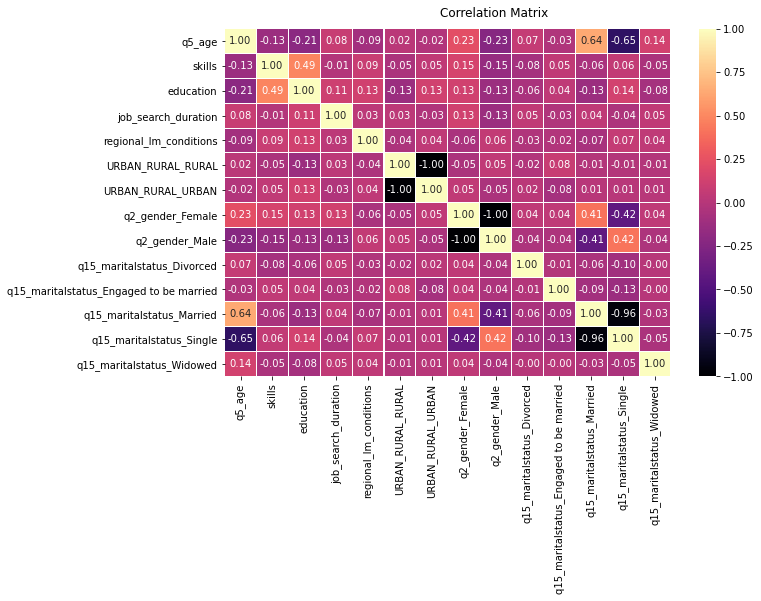

In [30]:
f, ax = plt.subplots(figsize=(10, 6))
corr = unemployed.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap='magma', fmt='.2f', linewidths=.05)
f.subplots_adjust(top=0.93)
t = f.suptitle('Correlation Matrix')

In [31]:
# drop additional [correlated] values of dummies
unemployed = unemployed.drop(columns=[
                      'q2_gender_Male',
                      'URBAN_RURAL_URBAN',
                      'q15_maritalstatus_Divorced',
                      'q15_maritalstatus_Engaged to be married',
                      'q15_maritalstatus_Single',
                      'q15_maritalstatus_Widowed'
                     ])

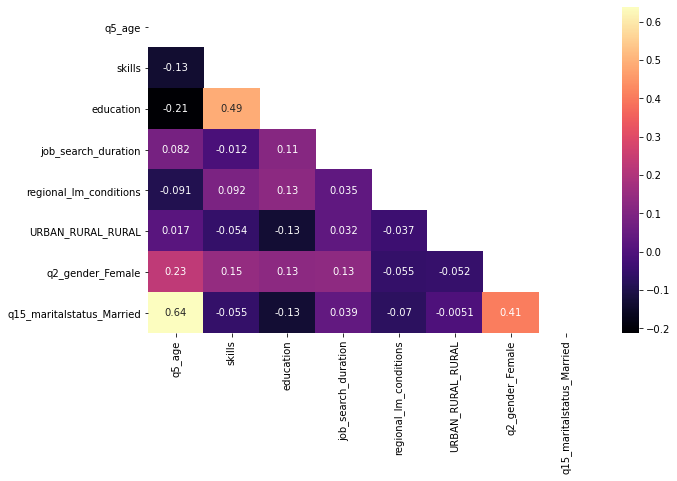

In [32]:
plt.subplots(figsize=(10, 6))
matrix = np.triu(unemployed.corr())
sns.heatmap(unemployed.corr(), annot=True, mask=matrix, cmap='magma');

In [33]:
# create new dataframe X for machine learning
X = unemployed

In [34]:
X

,q5_age,skills,education,job_search_duration,regional_lm_conditions,URBAN_RURAL_RURAL,q2_gender_Female,q15_maritalstatus_Married
2,34,2,2,3,11.1,0,1,1
3,38,1,1,2,11.1,0,1,1
19,36,1,1,2,11.1,0,1,1
23,24,1,2,2,11.1,0,1,1
32,26,3,3,4,11.1,0,1,1
...,...,...,...,...,...,...,...,...
4917,22,3,2,2,22.4,0,0,0
4929,45,1,1,2,14.6,0,1,1
4930,22,2,2,2,14.6,0,1,1
4932,27,1,2,1,11.1,0,1,1


# Scaling

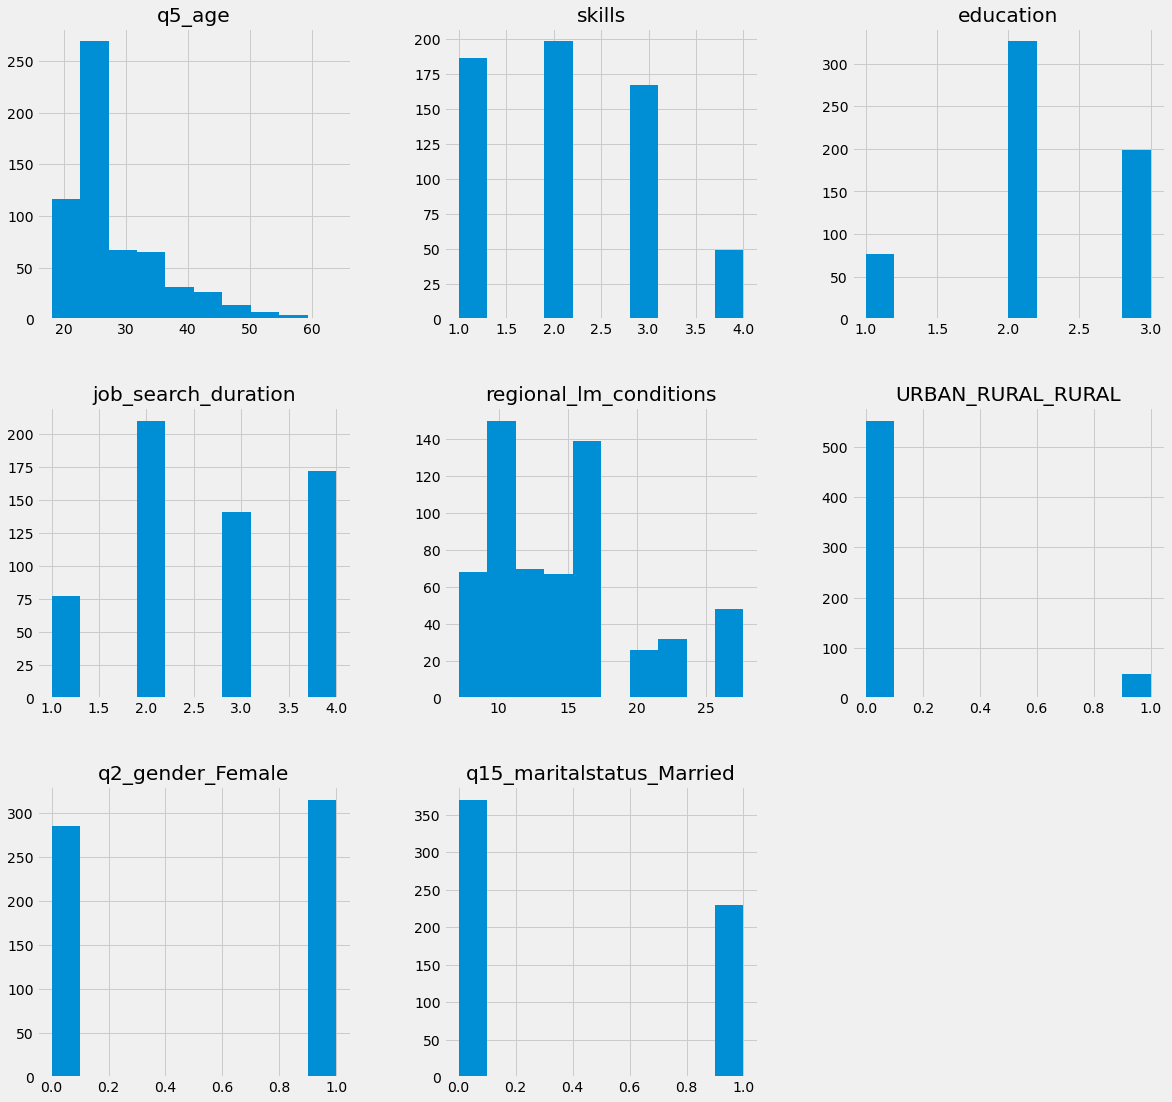

In [35]:
import matplotlib.style as style
style.use('fivethirtyeight')
X.hist(figsize=(18,18));

In [36]:
# Scaling method for one particular column (i.e., wages)
# if doing log transformation, some of the values might become -inf
# particularly if they are Zero values when scaled
# so we need to filter those values out and then replace 
# this is only if there are a few, otherwise find other method
# scale regional unemployment rates

def log_transform_clean(x):
    x=np.log(x)
    if np.isfinite(x):
        return x
    else:
        return np.NAN

X['regional_lm_conditions']=list(map(log_transform_clean, X['regional_lm_conditions']))

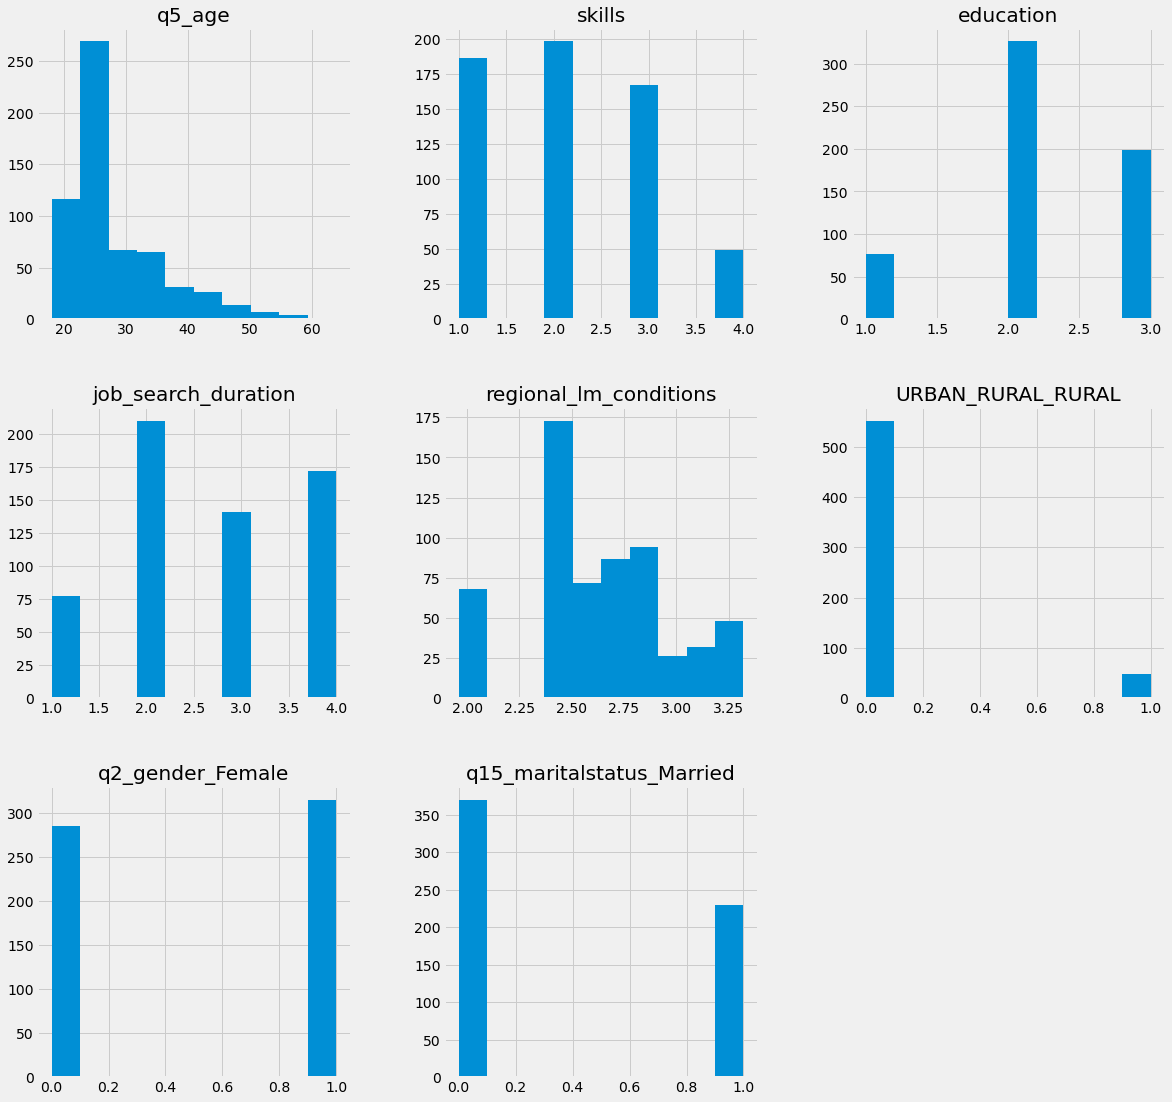

In [37]:
style.use('fivethirtyeight')
X.hist(figsize=(18,18));

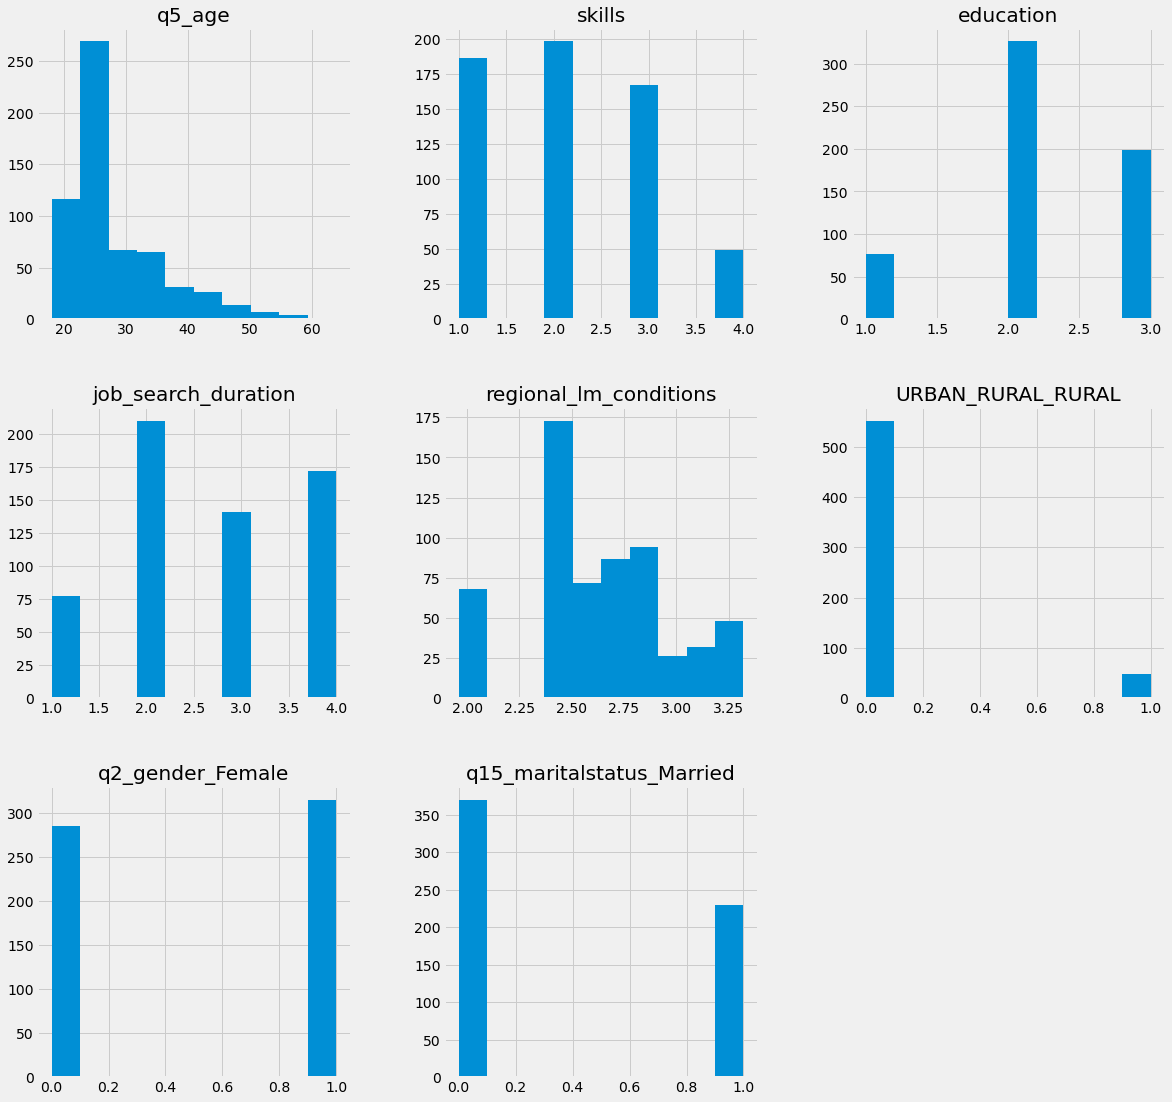

In [38]:
style.use('fivethirtyeight')
X.hist(figsize=(18,18));

# Standarize all numeric features
- rescaling using MinMax scaler

In [39]:
X.head()

,q5_age,skills,education,job_search_duration,regional_lm_conditions,URBAN_RURAL_RURAL,q2_gender_Female,q15_maritalstatus_Married
2,34,2,2,3,2.406945,0,1,1
3,38,1,1,2,2.406945,0,1,1
19,36,1,1,2,2.406945,0,1,1
23,24,1,2,2,2.406945,0,1,1
32,26,3,3,4,2.406945,0,1,1


In [40]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 2 to 4940
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   q5_age                     600 non-null    int64  
 1   skills                     600 non-null    int64  
 2   education                  600 non-null    int64  
 3   job_search_duration        600 non-null    int64  
 4   regional_lm_conditions     600 non-null    float64
 5   URBAN_RURAL_RURAL          600 non-null    uint8  
 6   q2_gender_Female           600 non-null    uint8  
 7   q15_maritalstatus_Married  600 non-null    uint8  
dtypes: float64(1), int64(4), uint8(3)
memory usage: 29.9 KB


In [41]:
X.isnull().sum()

q5_age                       0
skills                       0
education                    0
job_search_duration          0
regional_lm_conditions       0
URBAN_RURAL_RURAL            0
q2_gender_Female             0
q15_maritalstatus_Married    0
dtype: int64

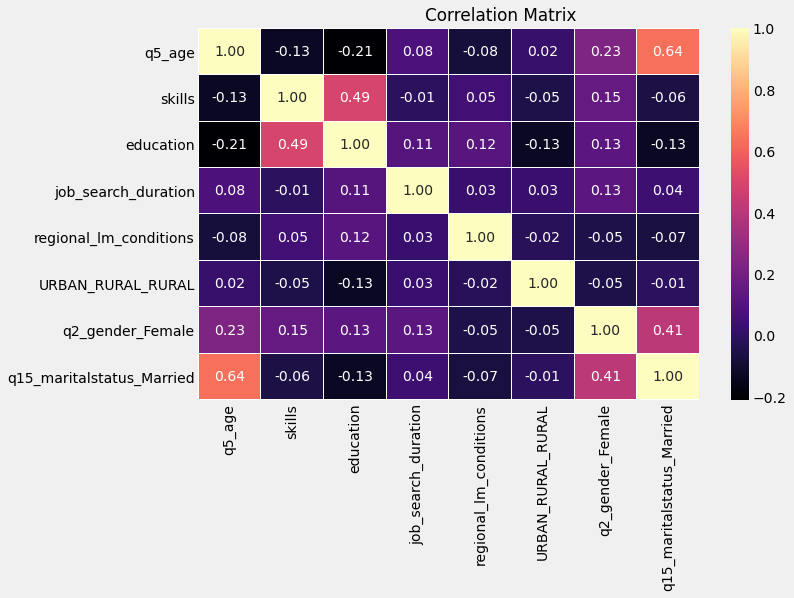

In [42]:
f, ax = plt.subplots(figsize=(10, 6))
corr = X.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap='magma', fmt='.2f', linewidths=.05)
f.subplots_adjust(top=0.93)
t = f.suptitle('Correlation Matrix')

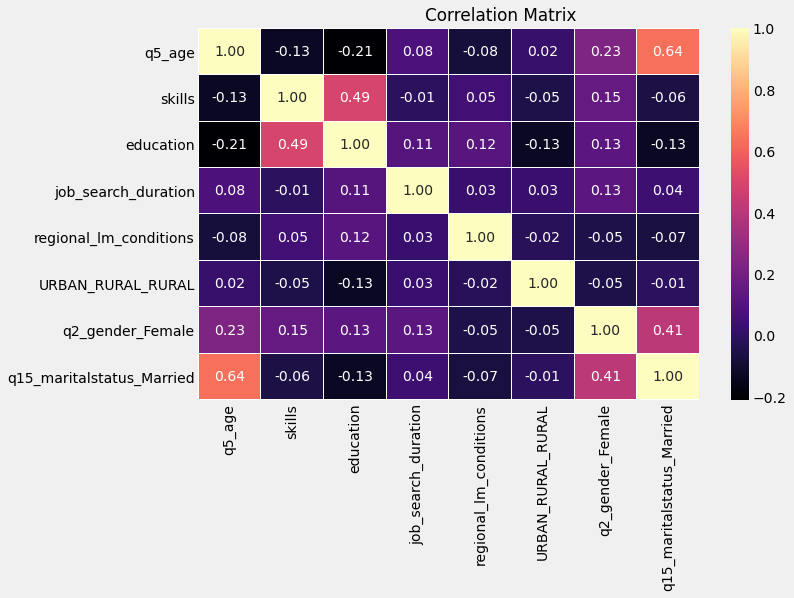

In [43]:
f, ax = plt.subplots(figsize=(10, 6))
corr = X.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap='magma', fmt='.2f', linewidths=.05)
f.subplots_adjust(top=0.93)
t = f.suptitle('Correlation Matrix')

# K-means

In [44]:
from sklearn.cluster import KMeans

# define the model, fit the model to the data 

kmeans = KMeans(n_clusters=3, random_state=40)
kmeans.fit(X)

KMeans(n_clusters=3, random_state=40)

In [45]:
#look at the cluster centres 
kmeans.cluster_centers_

array([[2.37696078e+01, 2.24754902e+00, 2.29166667e+00, 2.61764706e+00,
        2.65271325e+00, 8.08823529e-02, 4.24019608e-01, 1.61764706e-01],
       [3.37857143e+01, 1.93571429e+00, 2.12142857e+00, 2.92142857e+00,
        2.52814357e+00, 9.28571429e-02, 7.78571429e-01, 8.21428571e-01],
       [4.77307692e+01, 1.75000000e+00, 1.73076923e+00, 2.51923077e+00,
        2.62184930e+00, 3.84615385e-02, 6.34615385e-01, 9.42307692e-01]])

In [46]:
# Predicting / assigning the clusters:
clusters = kmeans.predict(X)

In [47]:
# Check the size of the clusters
pd.Series(clusters).value_counts().sort_index()

0    408
1    140
2     52
dtype: int64

In [48]:
# Explore the cluster assignment by placing it in the original dataset
X_cluster=pd.DataFrame(X)
X_cluster['cluster']=clusters
X_cluster.head(30)

,q5_age,skills,education,job_search_duration,regional_lm_conditions,URBAN_RURAL_RURAL,q2_gender_Female,q15_maritalstatus_Married,cluster
2,34,2,2,3,2.406945,0,1,1,1
3,38,1,1,2,2.406945,0,1,1,1
19,36,1,1,2,2.406945,0,1,1,1
23,24,1,2,2,2.406945,0,1,1,0
32,26,3,3,4,2.406945,0,1,1,0
33,36,1,2,2,2.406945,0,1,1,1
38,25,3,3,4,2.406945,0,1,0,0
39,23,2,2,4,2.406945,0,1,0,0
47,21,3,3,2,2.406945,0,1,0,0
58,31,2,1,2,2.785011,0,1,1,1


In [49]:
# Try to run Kmeans with all values of K, from 1 to 20
K = range(1, 20)

# For each model, store the inertia in a list
inertia = []

for k in K:
    
    kmeans=KMeans(n_clusters=k, random_state=40)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    
print(inertia)

[39609.651563201536, 12376.926612932115, 7025.270282346033, 4806.975910842124, 3814.6504353382957, 3071.771667896868, 2727.526324697865, 2445.7438182492424, 2242.7318679239575, 2108.722393417583, 2032.1362062338724, 1887.7037883960793, 1820.4952335574753, 1749.4502671707946, 1676.8549757056626, 1618.1935122900825, 1540.6329871785117, 1494.5118285942056, 1453.5825298057368]


Text(0.5, 1.0, 'Elbow Method showing the optimal k')

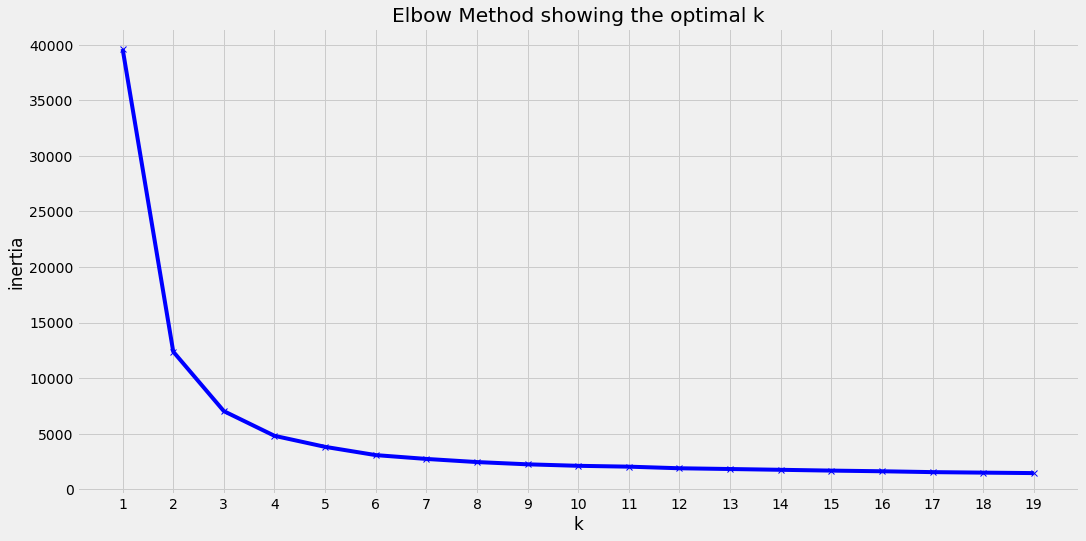

In [50]:
# Plot the results: Elbow method
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
style.use('fivethirtyeight')
plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

In [51]:
# Silhouette method

from sklearn.metrics import silhouette_score

K = range(2, 20)

silhouettes = []

for k in K: 
    kmeans=KMeans(n_clusters=k, random_state=40)
    kmeans.fit(X)
    silhouettes.append(silhouette_score(X, kmeans.predict(X)))

Text(0, 0.5, 'silhouette score')

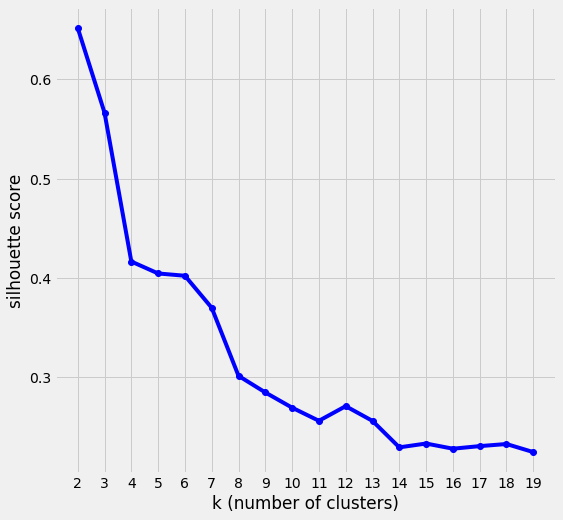

In [52]:
import matplotlib.pyplot as plt
style.use('fivethirtyeight')
plt.figure(figsize=(8,8))
plt.plot(K, silhouettes, 'bo-')
plt.xlabel('k (number of clusters)')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.ylabel('silhouette score')

In [53]:
kmeans = KMeans(n_clusters=4,
                init="random",
                n_init=10,  
                max_iter=200,
                tol=0,
                algorithm="full",
                random_state=40)
kmeans.fit(X)
print(kmeans.inertia_)

4806.975910842124


In [54]:
clusters = kmeans.predict(X)

In [55]:
# Check the size of the clusters
pd.Series(clusters).value_counts().sort_index()

0    101
1     52
2    285
3    162
dtype: int64

In [56]:
kmeans

KMeans(algorithm='full', init='random', max_iter=200, n_clusters=4,
       random_state=40, tol=0)

In [57]:
cluster_list = kmeans.predict(X)

In [58]:
X['cluster'] = cluster_list.tolist()

In [59]:
X

,q5_age,skills,education,job_search_duration,regional_lm_conditions,URBAN_RURAL_RURAL,q2_gender_Female,q15_maritalstatus_Married,cluster
2,34,2,2,3,2.406945,0,1,1,0
3,38,1,1,2,2.406945,0,1,1,0
19,36,1,1,2,2.406945,0,1,1,0
23,24,1,2,2,2.406945,0,1,1,2
32,26,3,3,4,2.406945,0,1,1,2
...,...,...,...,...,...,...,...,...,...
4917,22,3,2,2,3.109061,0,0,0,3
4929,45,1,1,2,2.681022,0,1,1,1
4930,22,2,2,2,2.681022,0,1,1,3
4932,27,1,2,1,2.406945,0,1,1,2


In [60]:
#predict the labels of clusters.
label = kmeans.fit_predict(X)

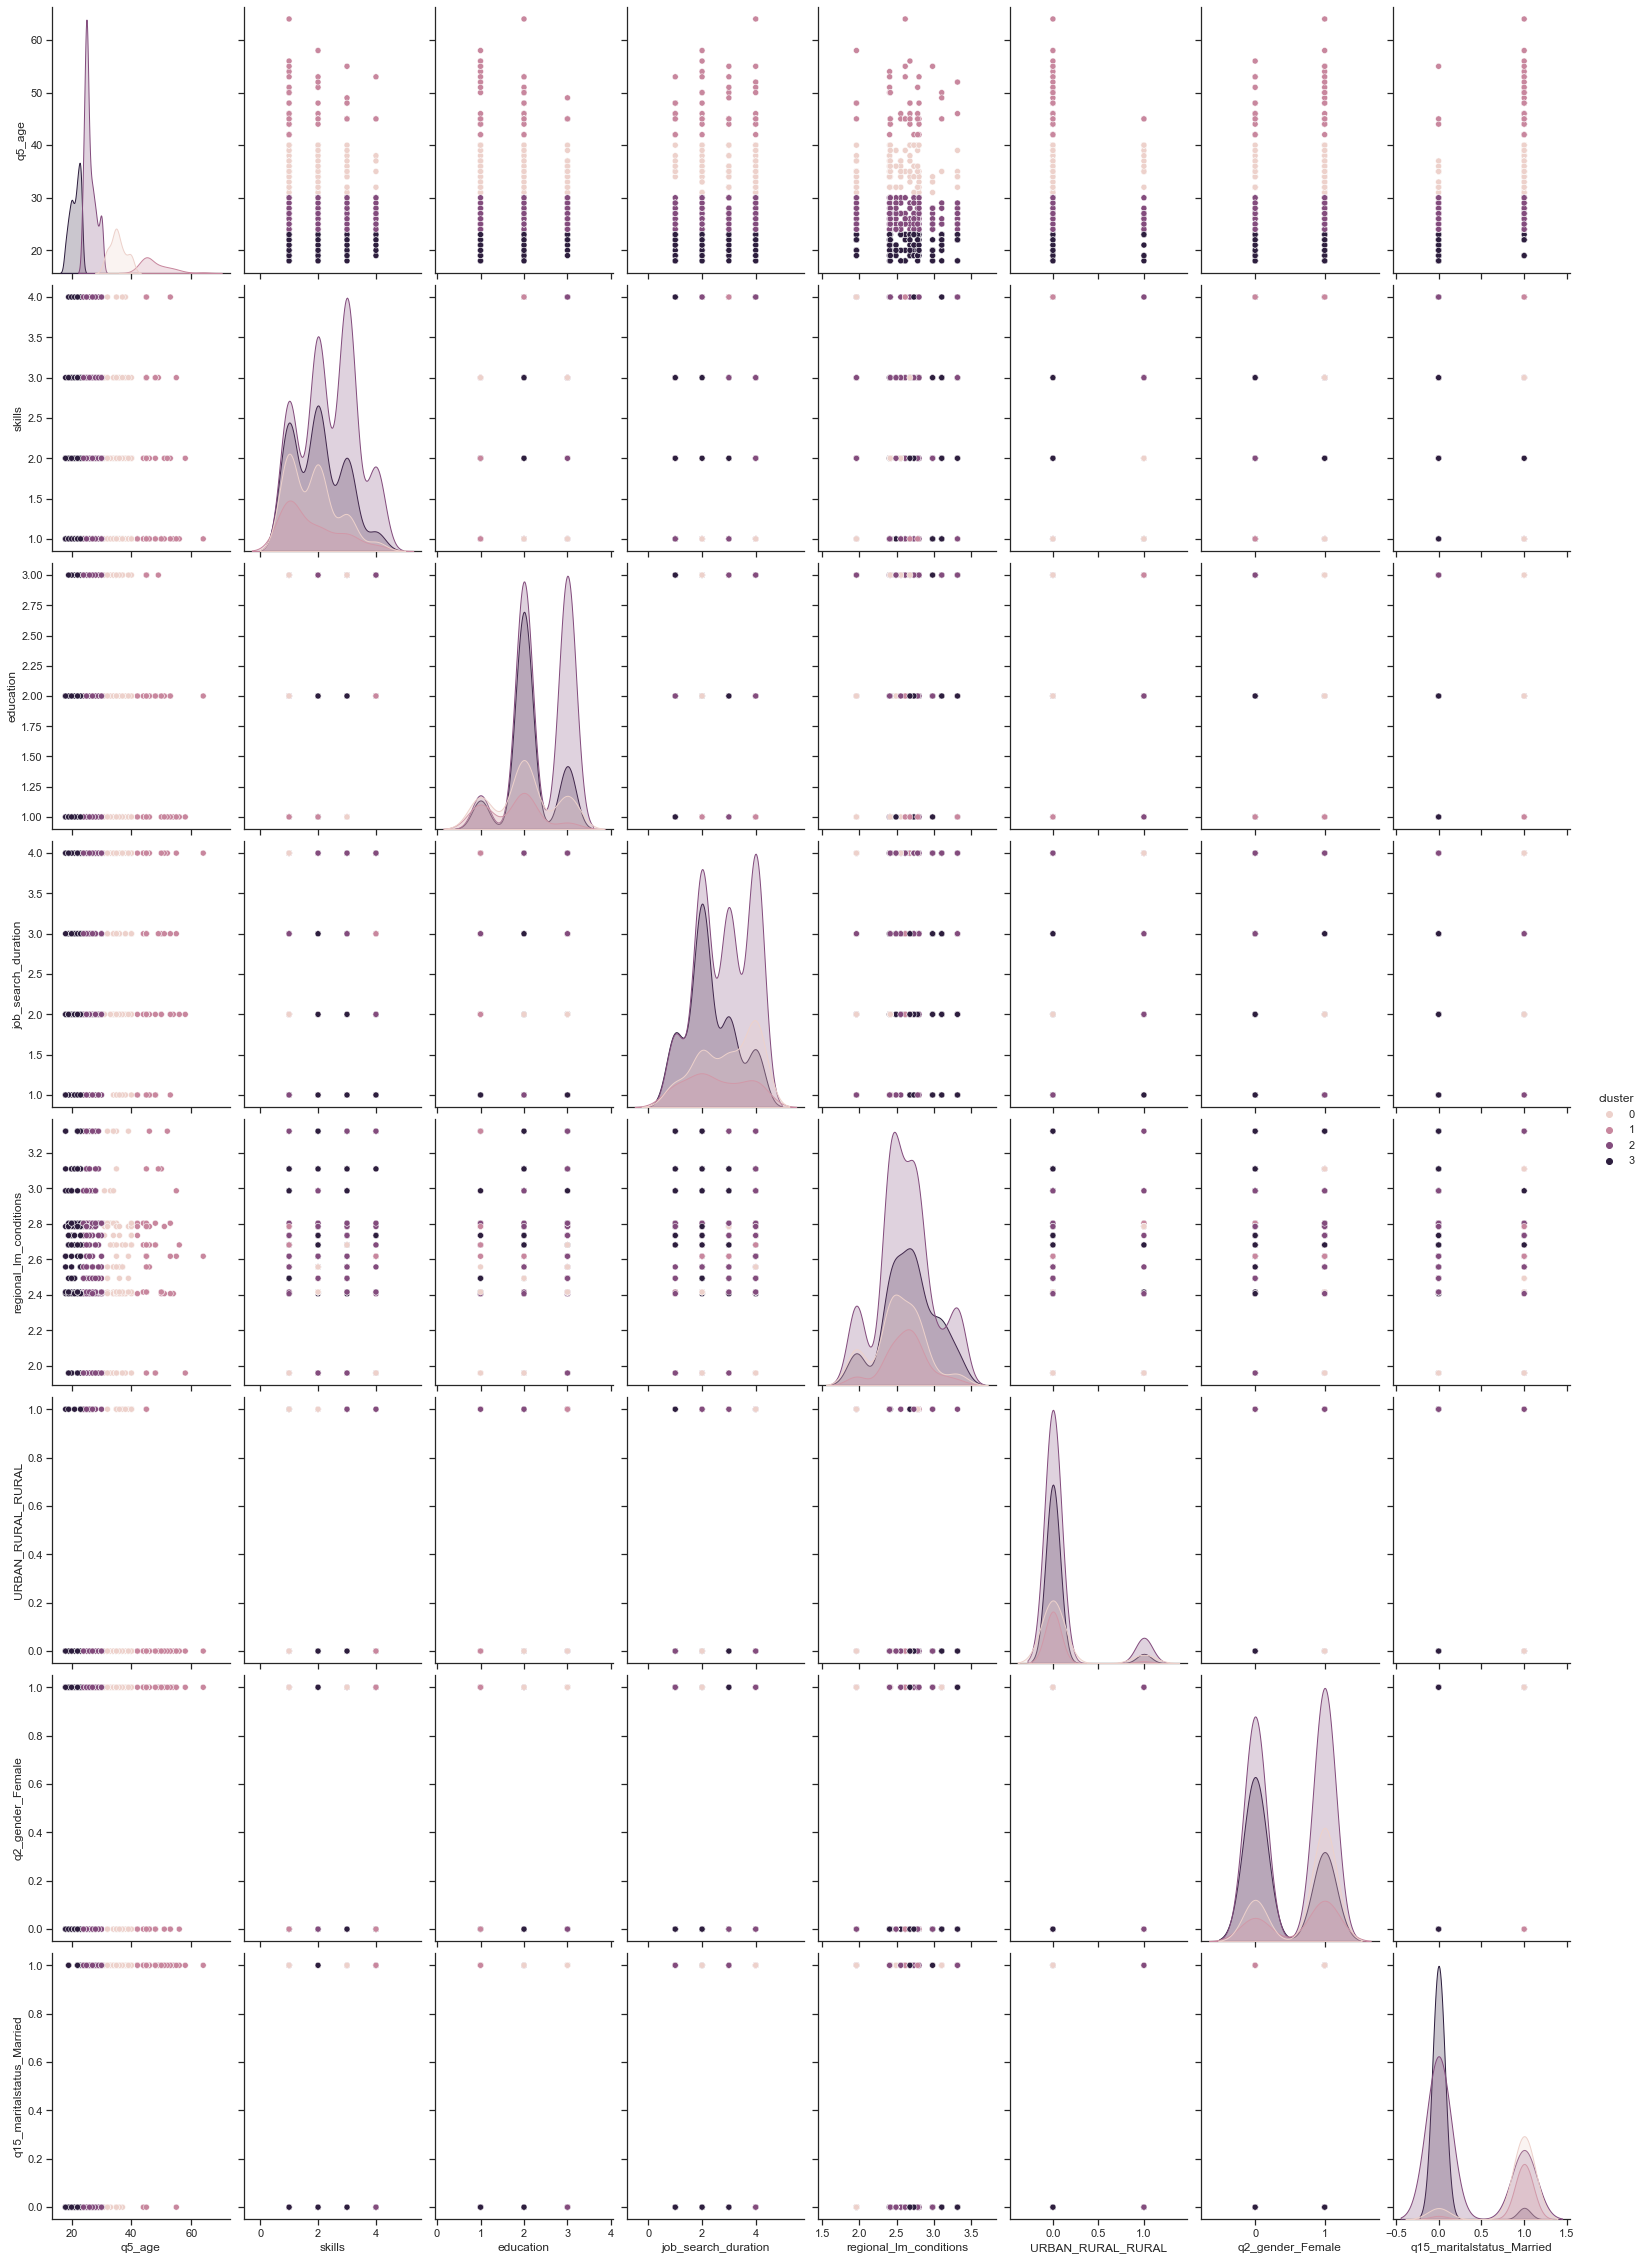

In [61]:
import seaborn as sns
sns.set_theme(style="ticks")

sns.pairplot(X, hue="cluster", height=4, aspect=.7)

In [63]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 2 to 4940
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   q5_age                     600 non-null    int64  
 1   skills                     600 non-null    int64  
 2   education                  600 non-null    int64  
 3   job_search_duration        600 non-null    int64  
 4   regional_lm_conditions     600 non-null    float64
 5   URBAN_RURAL_RURAL          600 non-null    uint8  
 6   q2_gender_Female           600 non-null    uint8  
 7   q15_maritalstatus_Married  600 non-null    uint8  
 8   cluster                    600 non-null    int64  
dtypes: float64(1), int64(5), uint8(3)
memory usage: 34.6 KB


In [64]:
y_kmeans = kmeans.fit_predict(X)

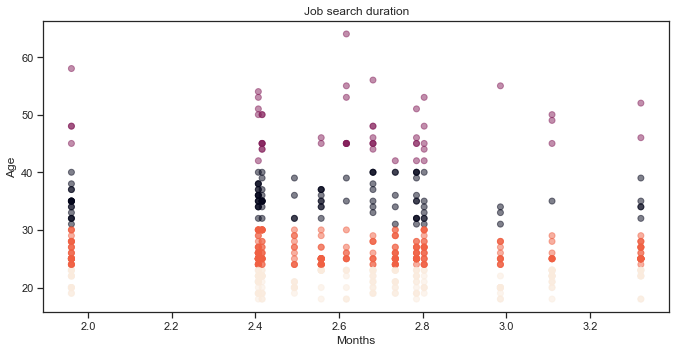

In [65]:
plt.figure(figsize=(10,5))
plt.scatter(X['regional_lm_conditions'], X['q5_age'], c=X['cluster'], alpha=0.5)
plt.title("Job search duration")
plt.xlabel("Months")
plt.ylabel("Age");
plt.show()

In [66]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 2 to 4940
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   q5_age                     600 non-null    int64  
 1   skills                     600 non-null    int64  
 2   education                  600 non-null    int64  
 3   job_search_duration        600 non-null    int64  
 4   regional_lm_conditions     600 non-null    float64
 5   URBAN_RURAL_RURAL          600 non-null    uint8  
 6   q2_gender_Female           600 non-null    uint8  
 7   q15_maritalstatus_Married  600 non-null    uint8  
 8   cluster                    600 non-null    int64  
dtypes: float64(1), int64(5), uint8(3)
memory usage: 34.6 KB


In [67]:
#Random forest

## Reference: The Mathematics of Decision Trees, Random Forest and Feature Importance in Scikit-learn and Spark
- https://towardsdatascience.com/the-mathematics-of-decision-trees-random-forest-and-feature-importance-in-scikit-learn-and-spark-f2861df67e3

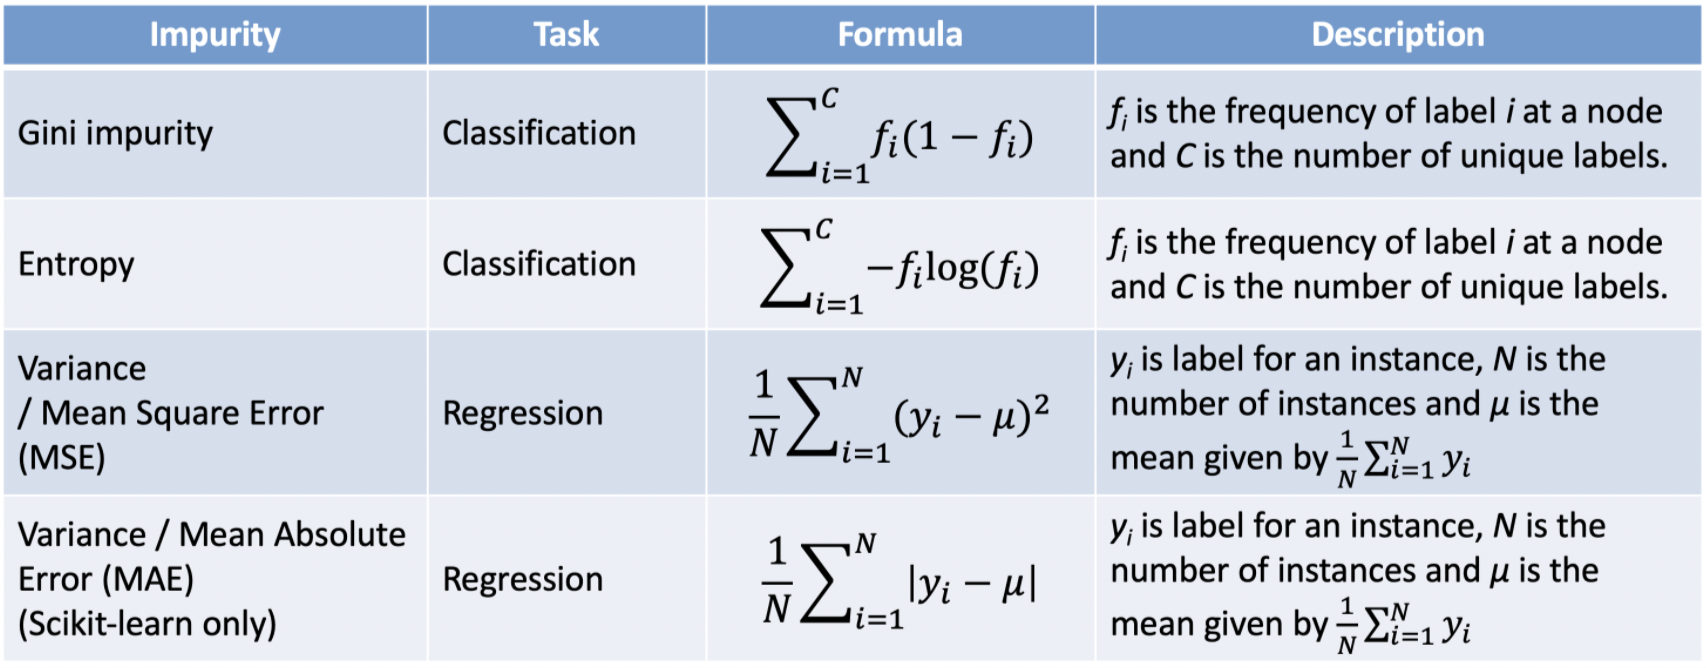

In [68]:
#Import library
from IPython.display import Image
# Load image from local storage
Image(filename = "random forest.png", width = 600, height = 300)

In [69]:
rf_df = X.drop(columns=['cluster'])

In [70]:
rf_df

,q5_age,skills,education,job_search_duration,regional_lm_conditions,URBAN_RURAL_RURAL,q2_gender_Female,q15_maritalstatus_Married
2,34,2,2,3,2.406945,0,1,1
3,38,1,1,2,2.406945,0,1,1
19,36,1,1,2,2.406945,0,1,1
23,24,1,2,2,2.406945,0,1,1
32,26,3,3,4,2.406945,0,1,1
...,...,...,...,...,...,...,...,...
4917,22,3,2,2,3.109061,0,0,0
4929,45,1,1,2,2.681022,0,1,1
4930,22,2,2,2,2.681022,0,1,1
4932,27,1,2,1,2.406945,0,1,1


In [71]:
# import the tools - for random forest
from sklearn.ensemble import RandomForestRegressor #calculated in the model .feature_importances_
from sklearn.feature_selection import SelectFromModel # you can try this one out after reviewing the documentation 

In [72]:
X=rf_df.drop(columns=['job_search_duration'])
y=rf_df['job_search_duration']

In [73]:
tree=RandomForestRegressor()

In [74]:
tree.fit(X,y)

RandomForestRegressor()

In [75]:
tree.feature_importances_

array([0.35127028, 0.14443484, 0.08344301, 0.27988319, 0.02860407,
       0.06683101, 0.04553359])

In [76]:
df_plot = pd.DataFrame(tree.feature_importances_)

In [77]:
sorted_col=tree.feature_importances_.argsort()

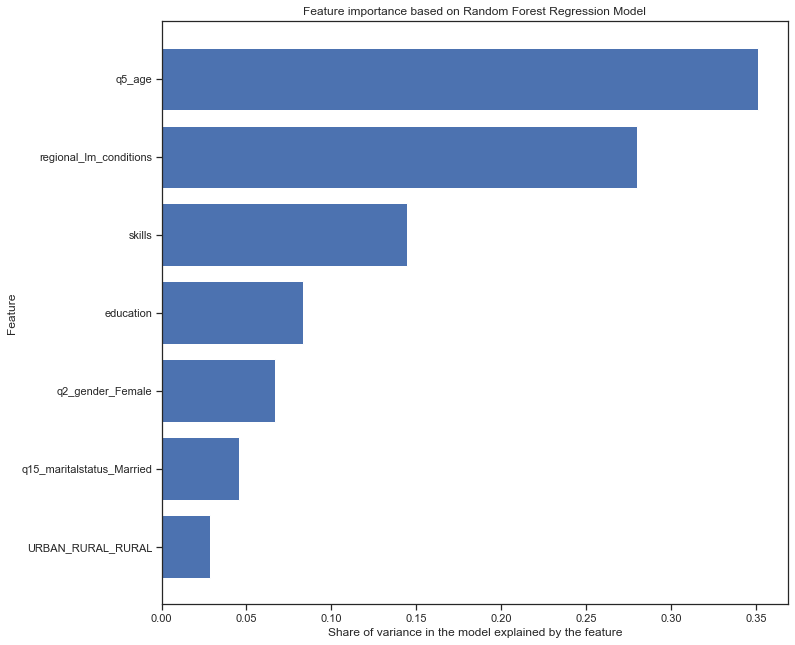

In [78]:
plt.figure(figsize=(10, 10))
plt.barh(X.columns[sorted_col],tree.feature_importances_[sorted_col])
plt.title("Feature importance based on Random Forest Regression Model")
plt.xlabel("Share of variance in the model explained by the feature")
plt.ylabel("Feature");

## Feature Importance
- Feature importance is calculated as the decrease in node impurity weighted by the probability of reaching that node. The node probability can be calculated by the number of samples that reach the node, divided by the total number of samples. The higher the value the more important the feature.